In [17]:
import numpy as np
import matplotlib.pyplot as plt
from TidalPy.RadialSolver import radial_solver as radial_solver_new
from TidalPy.radial_solver import radial_solver as radial_solver_old
from TidalPy.utilities.graphics.multilayer import yplot
from TidalPy.rheology.models import Maxwell, Andrade, Elastic
from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays

## 1 Layer

In [ ]:
def test_1layer():
    frequency = np.pi * 2. / (86400. * 7.5)
    
    radius_array = np.linspace(0.1, 6000.0e3, 100)
    indices_by_layer = radius_array > 0.
    density_array = np.ones_like(radius_array) * 5400.
    planet_bulk_density = np.average(density_array)
    bulk_modulus_array = np.ones_like(radius_array) * 1.0e11
    shear_array = np.ones_like(radius_array) * 50.0e9
    viscosity_array = np.ones_like(radius_array) * 1.0e18

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)
    
    input_new_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        gravity_array=gravity_array,
        bulk_modulus_array=bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=('solid',),
        is_static_by_layer=(False,),
        is_incompressible_by_layer=(False,),
        upper_radius_by_layer=(radius_array[-1],),
        degree_l = 2,
        solve_for = None,
        use_kamata = False,
        integration_method = 'DOP853',
        integration_rtol = 1.0e-9,
        integration_atol = 1.0e-12,
        scale_rtols_by_layer_type = False,
        max_num_steps = 500_000,
        expected_size = 500,
        max_ram_MB = 500,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = False,
        verbose = False,
        raise_on_fail = False,     
    )

    input_old_dict = dict(        
        radius=radius_array,
        density=density_array,
        gravity=gravity_array,
        bulk_modulus=bulk_modulus_array,
        shear_modulus=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        is_solid_by_layer=(True,),
        is_static_by_layer=(False,),
        indices_by_layer=(indices_by_layer,),
        order_l = 2,
        surface_boundary_condition=None, 
        solve_load_numbers=False,
        use_kamata = False,
        integration_method = 'DOP853',
        integrator = 'scipy',
        integration_rtol = 1.0e-9,
        integration_atol = 1.0e-12,
        nondimensionalize = False,
        verbose = False,
        incompressible = False,        
    )

    new_result = radial_solver_new(**input_new_dict)
    old_ys = radial_solver_old(**input_old_dict)

    new_ys = new_result.result

    print(f'Old size: {old_ys.shape}; new: {new_ys.shape}.')
    yplot([old_ys, new_ys], [radius_array, radius_array], colors=['r', 'b'])
    
    percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)
    percent_diff[np.logical_and(np.isclose(old_ys, 0. + 0.j), np.isclose(new_ys, 0. + 0.j))] = np.nan
    yplot([percent_diff], [radius_array])

    print(new_ys[1, -1])

test_1layer()

# 2 Layers


 DEB_OLD:: nondimensionalize True
: [[ 1.02070768e-22+0.j  1.39221823e-06+0.j -1.39221823e-06+0.j
  -4.17665469e+02+0.j]
 [ 3.33333333e-08+0.j  0.00000000e+00+0.j -2.72835188e-14+0.j
  -8.31838896e-06+0.j]];
Old size: (6, 100); new: (6, 100).


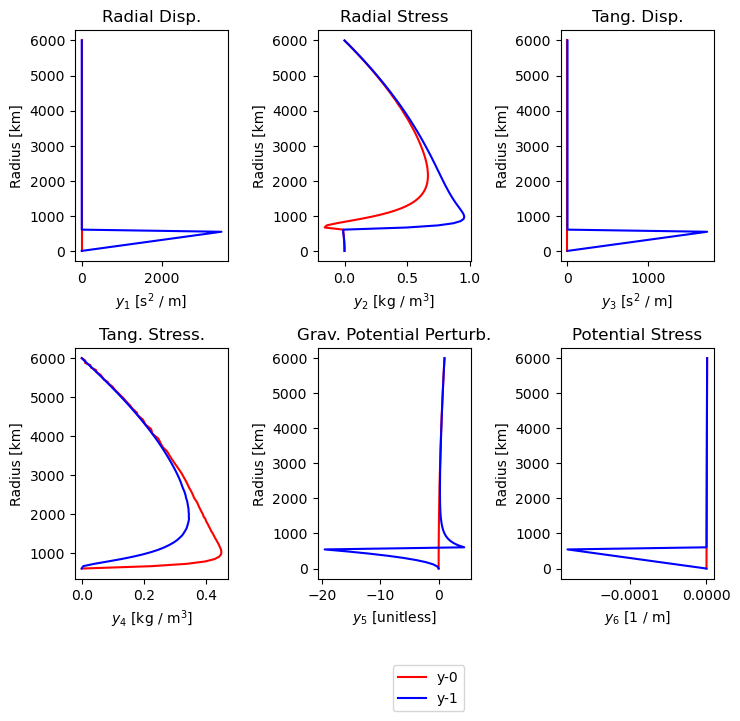

C:\Users\joepr\AppData\Local\Temp\ipykernel_30348\1648339146.py:100: RuntimeWarning: invalid value encountered in divide
  percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)


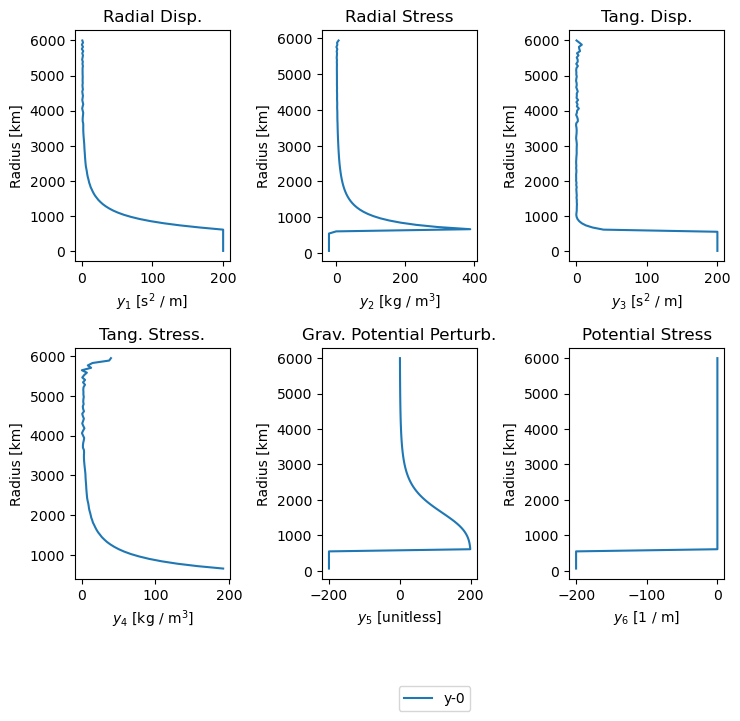

(-1.7763568394002505e-15-1.6653345369377348e-16j)


In [16]:
def test_2layer():
    layer_types = ('liquid', 'solid')
    is_solid_by_layer = (False, True)
    is_static_by_layer = (False, False)
    integration_method = 'RK45'
    integration_rtol = 1.0e-8
    integration_atol = 1.0e-10
    nondimensionalize = True
    is_incompressible_by_layer = (False, False)
    use_kamata = False
    
    radius_array = np.linspace(0.1, 6000.0e3, 100)
    CMB_radius = 0.1 * radius_array[-1]
    upper_radius_by_layer = (CMB_radius, radius_array[-1])
    
    frequency = np.pi * 2. / (86400. * 0.5)
    
    ic_index = radius_array <= CMB_radius
    mantle_index = radius_array > CMB_radius
    
    indices_by_layer = (ic_index, mantle_index)
    density_array = np.ones_like(radius_array) * 1.
    density_array[ic_index] = 1.
    planet_bulk_density = np.average(density_array)
    bulk_modulus_array = np.ones_like(radius_array) * 1.0e11
    bulk_modulus_array[ic_index] = 5.0e11
    shear_array = np.ones_like(radius_array) * 50.0e9
    shear_array[ic_index] = 0.
    viscosity_array = np.ones_like(radius_array) * 1.0e18
    viscosity_array[ic_index] = 1000.

    rheo_inst = Andrade()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)
    
    input_new_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        gravity_array=gravity_array,
        bulk_modulus_array=bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=layer_types,
        is_static_by_layer=is_static_by_layer,
        is_incompressible_by_layer=is_incompressible_by_layer,
        upper_radius_by_layer=upper_radius_by_layer,
        degree_l = 2,
        solve_for = None,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        scale_rtols_by_layer_type = False,
        max_num_steps = 5_000_000,
        expected_size = 1000,
        max_ram_MB = 3000,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = nondimensionalize,
        verbose = False,
        raise_on_fail = False,     
    )

    input_old_dict = dict(        
        radius=radius_array,
        density=density_array,
        gravity=gravity_array,
        bulk_modulus=bulk_modulus_array,
        shear_modulus=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        is_solid_by_layer=is_solid_by_layer,
        is_static_by_layer=is_static_by_layer,
        indices_by_layer=indices_by_layer,
        order_l = 2,
        surface_boundary_condition=None, 
        solve_load_numbers=False,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integrator = 'cyrk',
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        nondimensionalize = nondimensionalize,
        verbose = False,
        incompressible = False,        
    )

    new_result = radial_solver_new(**input_new_dict)
    old_ys = radial_solver_old(**input_old_dict)

    new_ys = new_result.result

    print(f'Old size: {old_ys.shape}; new: {new_ys.shape}.')
    yplot([old_ys, new_ys], [radius_array, radius_array], colors=['r', 'b'])
    
    percent_diff = 200 * np.abs(old_ys - new_ys) / (old_ys + new_ys)
    percent_diff[np.logical_and(np.isclose(old_ys, 0. + 0.j), np.isclose(new_ys, 0. + 0.j))] = np.nan
    yplot([percent_diff], [radius_array])

    print(new_ys[1, -1])

test_2layer()

## Nodim vs dim compare

[0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j
 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j]

 DEB_OLD:: nondimensionalize False
: [[-3.57728917e-15+0.j -8.94322292e-02+0.j  1.11790286e-05+0.j
   5.58951432e-04+0.j]
 [ 2.00000000e+01+0.j  0.00000000e+00+0.j  3.94430911e-06+0.j
   6.30206915e-05+0.j]];
[0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j 0.e+00+0.j
 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j
 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j 5.e+10+0.j]

 DEB_OLD:: nondimensionalize True
: [[-3.57728917e-12+0.j -8.80480983e+00+0.j  7.66018455e+00+0.j
   3.83009228e+05+0

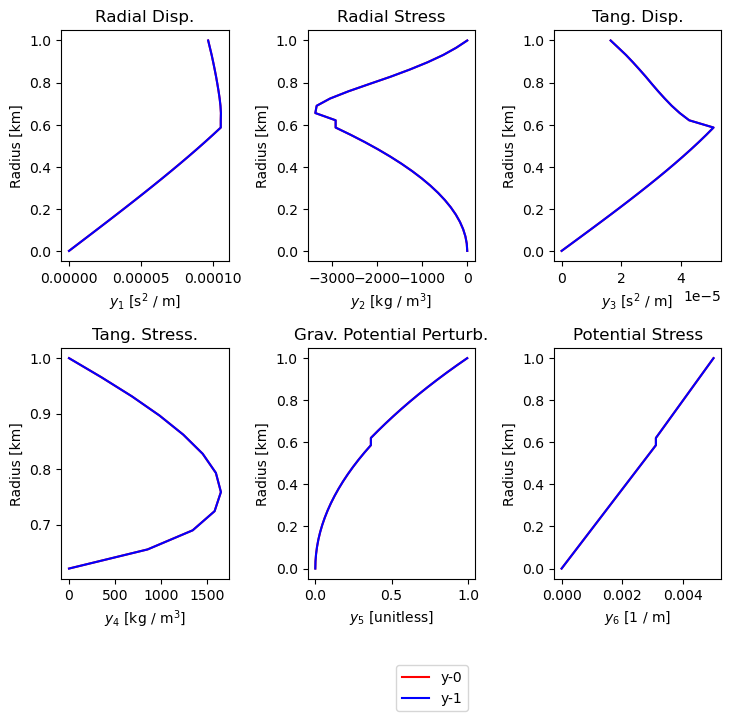

New RS (r=Dim; b=NoDim)


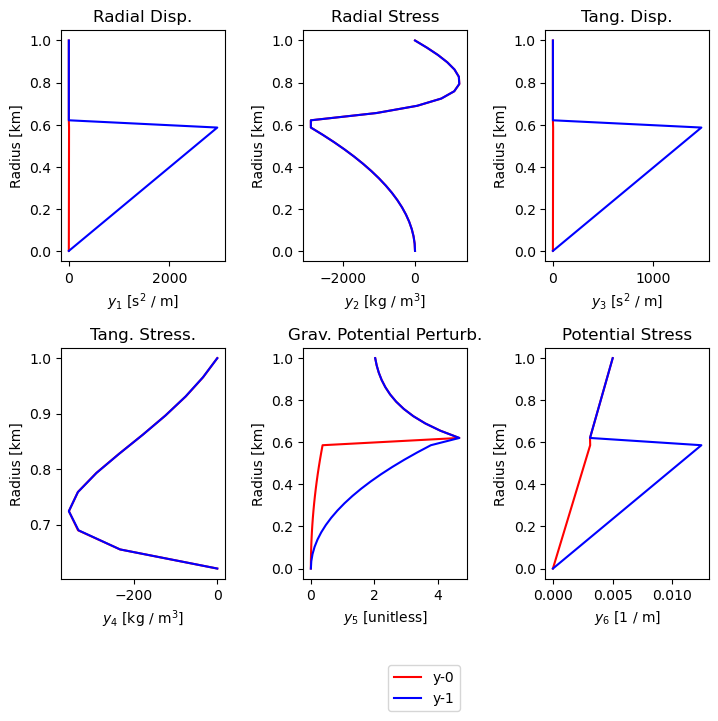

Dim (r=Old, b=New)


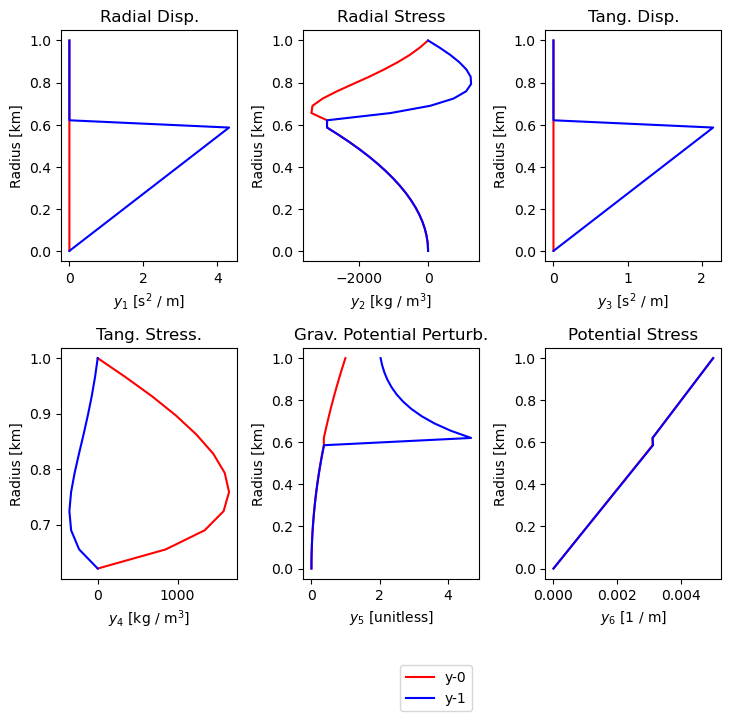

NoDim (r=Old, b=New)


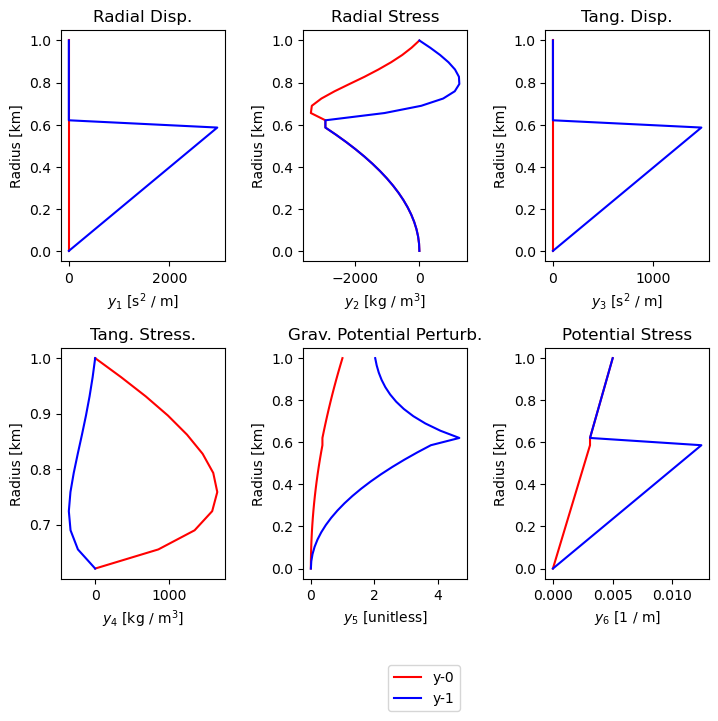

In [18]:
def test_dim_nodim():
    layer_types = ('liquid', 'solid')
    is_solid_by_layer = (False, True)
    is_static_by_layer = (False, False)
    integration_method = 'RK45'
    integration_rtol = 1.0e-8
    integration_atol = 1.0e-10
    is_incompressible_by_layer = (False, False)
    use_kamata = True
    
    radius_array = np.linspace(0.1, 1.0e3, 30)
    CMB_radius = 0.6 * radius_array[-1]
    upper_radius_by_layer = (CMB_radius, radius_array[-1])
    
    frequency = np.pi * 2. / (86400. * 0.1)
    
    ic_index = radius_array <= CMB_radius
    mantle_index = radius_array > CMB_radius
    
    indices_by_layer = (ic_index, mantle_index)
    density_array = np.ones_like(radius_array) * 5400.
    density_array[ic_index] = 8000.
    planet_bulk_density = np.average(density_array)
    bulk_modulus_array = np.ones_like(radius_array) * 1.0e11
    bulk_modulus_array[ic_index] = 5.0e11
    shear_array = np.ones_like(radius_array) * 50.0e9
    shear_array[ic_index] = 0.
    viscosity_array = np.ones_like(radius_array) * 1.0e18
    viscosity_array[ic_index] = 1000.

    rheo_inst = Elastic()
    complex_shear_modulus_array = np.empty(radius_array.size, dtype=np.complex128)
    rheo_inst.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)
    
    volume_array, mass_array, gravity_array = \
        calculate_mass_gravity_arrays(radius_array, density_array)
    
    input_new_dict = dict(
        radius_array=radius_array,
        density_array=density_array,
        gravity_array=gravity_array,
        bulk_modulus_array=bulk_modulus_array,
        complex_shear_modulus_array=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        layer_types=layer_types,
        is_static_by_layer=is_static_by_layer,
        is_incompressible_by_layer=is_incompressible_by_layer,
        upper_radius_by_layer=upper_radius_by_layer,
        degree_l = 2,
        solve_for = None,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        scale_rtols_by_layer_type = False,
        max_num_steps = 5_000_000,
        expected_size = 1000,
        max_ram_MB = 3000,
        max_step = 0,
        limit_solution_to_radius = True,
        nondimensionalize = False,
        verbose = False,
        raise_on_fail = False,     
    )

    input_old_dict = dict(        
        radius=radius_array,
        density=density_array,
        gravity=gravity_array,
        bulk_modulus=bulk_modulus_array,
        shear_modulus=complex_shear_modulus_array,
        frequency=frequency,
        planet_bulk_density=planet_bulk_density,
        is_solid_by_layer=is_solid_by_layer,
        is_static_by_layer=is_static_by_layer,
        indices_by_layer=indices_by_layer,
        order_l = 2,
        surface_boundary_condition=None, 
        solve_load_numbers=False,
        use_kamata = use_kamata,
        integration_method = integration_method,
        integrator = 'cyrk',
        integration_rtol = integration_rtol,
        integration_atol = integration_atol,
        nondimensionalize = False,
        verbose = False,
        incompressible = False,        
    )
    print(complex_shear_modulus_array)
    
    new_result_dim = radial_solver_new(**input_new_dict)
    old_ys_dim = radial_solver_old(**input_old_dict)
    new_ys_dim = np.copy(new_result_dim.result)

    input_new_dict['nondimensionalize'] = True
    input_old_dict['nondimensionalize'] = True
    input_new_dict['integration_atol'] /= 1
    input_old_dict['integration_atol'] /= 1
    input_new_dict['integration_rtol'] /= 1
    input_old_dict['integration_rtol'] /= 1
    
    print(complex_shear_modulus_array)

    new_result_nodim = radial_solver_new(**input_new_dict)
    old_ys_nodim = radial_solver_old(**input_old_dict)
    new_ys_nodim = np.copy(new_result_nodim.result)

    print('Old RS (r=Dim; b=NoDim)')
    yplot([old_ys_dim, old_ys_nodim], [radius_array, radius_array], colors=['r', 'b'])

    print('New RS (r=Dim; b=NoDim)')
    yplot([new_ys_dim, new_ys_nodim], [radius_array, radius_array], colors=['r', 'b'])
    
    print('Dim (r=Old, b=New)')
    yplot([old_ys_dim, new_ys_dim], [radius_array, radius_array], colors=['r', 'b'])
    
    print('NoDim (r=Old, b=New)')
    yplot([old_ys_nodim, new_ys_nodim], [radius_array, radius_array], colors=['r', 'b'])
    

test_dim_nodim()